In [ ]:
%cd ~/../kaggle/working
!git clone https://github.com/RSourceCode/SAM2.git

In [ ]:
%cd SAM2
!pip install sam2
!pip install -e .

In [ ]:
%cd checkpoints
!bash download_ckpts.sh
%cd ../notebooks

In [ ]:
## All required imports ##
import os
import sys
import numpy as np 
import cv2 
import matplotlib.pyplot as plt
import torch
import traceback

from torch.onnx.symbolic_opset11 import hstack

from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor



In [ ]:
####  Helper functions  ####

# Get coco's file name from paco's file name
def getName(str_name):
    name = str_name.split('_')[0]
    return (12-len(name))*'0' + name + ".jpg"

# Resize imag to 1024 x 1024 to make it compatible with SAM2
def resizeImage(img):
    r = min(1024 / img.shape[1], 1024 / img.shape[0])
    _img = cv2.resize(img, (int(img.shape[1] * r), int(img.shape[0] * r)), interpolation=cv2.INTER_NEAREST)
    _img = np.pad(_img, ((0, 1024 - _img.shape[0]), (0, 1024 - _img.shape[1]), (0, 0)), mode='constant') # add padding to the bottom and right of image
    return _img

def getIdFromPath(path):
    return path.split('/')[-1].split('_')[0]

def visualise(image, masks = None, input_points = None, input_labels = None):
    
    plt.subplot(len(masks + 1) // 5 + 1, 5, 1)
    plt.imshow(image)
    
    if masks is not None:
        for i in range(len(masks)):
            if(input_labels is not None):
                if(input_labels[i] == 1): plt.scatter(input_points[i][0][0], input_points[i][0][1], color='blue')
                else: plt.scatter(input_points[i][0][0], input_points[i][0][1], color='red')
            plt.subplot(len(masks + 1) // 5 + 1, 5, i + 2)
            plt.imshow(masks[i],cmap="binary")
                

In [ ]:
# Read data
data_dir=r"../../../input/" # Path to dataset
print(os.getcwd())

idToCoordsMap = {} # map of each coco image to a point in each annotation mask
data=[] # list of files in dataset

for ff, name in enumerate(os.listdir(data_dir+"paco-bw-mask-val/kaggle/working/reupdated-paco-masks-val/val/")):  # go over all folder annotation
    data.append({"image":data_dir+"coco-2017-dataset/coco2017/train2017/"+getName(name),"annotation":data_dir+"paco-bw-mask-val/kaggle/working/reupdated-paco-masks-val/val/"+name})
    if name.split('_')[0] not in idToCoordsMap:
        idToCoordsMap[name.split('_')[0]] = []
        
    ann_map = cv2.imread(data[len(data) - 1]["annotation"])
    ann_map = resizeImage(ann_map)
    mask = (ann_map > 150)[:, :, 0].astype(np.uint8) # convert bgr image to binary mask
    
    coords = np.argwhere(mask > 0) # get all coordinates of one mask 
    if len(coords) == 0: continue # fail safe
        
    yx = coords[np.random.randint(len(coords))]  # format: [y, x]
    point = [[yx[1], yx[0]]]  # format: [x, y] for SAM2
    idToCoordsMap[name.split('_')[0]].append(point)


In [ ]:
name = ["100034_6861.jpg","100034_6862.jpg","100034_6863.jpg"]
file = ["../../../input/paco-bw-mask-val/kaggle/working/reupdated-paco-masks-val/val/100034_6861.jpg", "../../../input/paco-bw-mask-val/kaggle/working/reupdated-paco-masks-val/val/100034_6862.jpg", "../../../input/paco-bw-mask-val/kaggle/working/reupdated-paco-masks-val/val/100034_6863.jpg"]
idToCordsMap = {}
plt.subplots(1,3,figsize = (12,12))
for i in range(3):
    if name[i].split('_')[0] not in idToCordsMap:
            idToCordsMap[name[i].split('_')[0]] = []
    # print(data["annotation"])
    ann_map = cv2.imread(file[i])
    ann_map = resizeImage(ann_map)
    mask = (ann_map > 150)[:, :, 0].astype(np.uint8)
    coords = np.argwhere(mask > 0)
    # if len(coords) == 0: print("Lol")
    # yx = coords[np.random.randint(len(coords))]  # format: [y, x]
    # point = [[yx[1], yx[0]]]  # format: [x, y] for SAM2
    # idToCordsMap[name[i].split('_')[0]].append(point)
 
    plt.subplot(1, 3, i + 1)
    labels = [];

    # print(coords)
    for coord in idToCoordsMap['100034']:
        print(coord[0])
        if any(np.array_equal(coord[0][::-1], c) for c in coords):
            labels.append(1)
            plt.scatter(coord[0][0], coord[0][1], color='blue')
        else:
            plt.scatter(coord[0][0], coord[0][1], color='red')
            labels.append(0)
    # print(idToCordsMap[name[i].split('_')[0]][i][0])
    plt.imshow(mask)

In [ ]:
def read_single(data):
    # Select random image-mask pair
    ent = data[np.random.randint(len(data))]
    # print(ent)
    if(ent['image'] is None):
        return None,None,None
    Img = cv2.imread(ent["image"])[..., ::-1]  # RGB image
    ann_map = cv2.imread(ent["annotation"])    # BGR annotation map with different part colors
    
    # Resize image and annotation to 1024x1024 (pad if needed)
    Img = resizeImage(Img)
    ann_map = resizeImage(ann_map)
    
    mask = (ann_map > 150)[:, :, 0].astype(np.uint8)
    
    coords = np.argwhere(mask > 0)
    if len(coords) == 0: return Img,mask,None
    # yx = [0,0]
    # print(coords)
    # print()
    labels = []
    for coord in idToCoordsMap[getIdFromPath(ent['annotation'])]:
        # print(coord)
        # if any(np.array_equal(coord[0][::-1], c) for c in coords):
        if coord[0][::-1] in coords.tolist():
            # print(coord[0][::-1], "exists")
            labels.append([1])
        else:
            labels.append([0])
    # print(labels)     
    points = idToCoordsMap[getIdFromPath(ent['annotation'])]
    # print(f"points = {points} ,labels = {labels}")
    return Img, mask, points, labels
    
data_dir=r"../../../input/" # Path to dataset (LabPics 1)
print(os.getcwd())

# def read_single_test(data, name):
#     # Select random image-mask pair
#     ent ={"image":data_dir+"coco-2017-dataset/coco2017/train2017/"+getName(name),"annotation":data_dir+"paco-bw-mask-val/kaggle/working/reupdated-paco-masks-val/val/"+name}
#     print(ent)
#     if(ent['image'] is None):
#         return None, None ,None ,None
#     Img = cv2.imread(ent["image"])[..., ::-1]  # RGB image
#     ann_map = cv2.imread(ent["annotation"])    # BGR annotation map with different part colors
    
#     # Resize image and annotation to 1024x1024 (pad if needed)
#     Img = resizeImage(Img)
#     ann_map = resizeImage(ann_map)
    
#     mask = (ann_map > 150)[:, :, 0].astype(np.uint8)
    
#     coords = np.argwhere(mask > 0)
#     if len(coords) == 0: return Img,mask,None, None
#     # yx = [0,0]
#     labels = []
#     print(coords)
#     for coord in idToCoordsMap[getIdFromPath(ent['annotation'])]:
#         print(coord[0][::-1])
#         if any(np.array_equal(coord[0][::-1], c) for c in coords):
#             labels.append([1])
#         else:
#             labels.append([0])
            
#     points = idToCoordsMap[getIdFromPath(ent['annotation'])]
#     print(f"points = {points} ,labels = {labels}")
#     return Img, mask, points, labels
    
# def read_batch(data,batch_size=4):
#       limage = []
#       lmask = []
#       linput_point = []
#       for i in range(batch_size):
#               image,mask,input_point = read_single(data)
#               limage.append(image)
#               lmask.append(mask)
#               linput_point.append(input_point)

#       return limage, np.array(lmask), np.array(linput_point),  np.ones([batch_size,1])


In [ ]:
!ls

In [ ]:
image, mask, input_points, input_labels = read_single(data)  # load data batch
plt.subplots(1,2,figsize = (12,12))
plt.subplot(1, 2, 1)
plt.imshow(image)

plt.subplot(1, 2, 2)
for indx, point in enumerate(input_points):
    if(input_labels[indx] == [0]): plt.scatter(point[0][0], point[0][1], color="red", marker="o")  # Use scatter to plot a distinct point
    else: plt.scatter(point[0][0], point[0][1], color="blue", marker="o") 

plt.imshow(mask)

plt.show()


In [ ]:
#  This script is used to load the SAM2 model and create a predictor instance.
# It assumes that the SAM2 model files are located in the specified paths.

sam2_checkpoint = "../checkpoints/sam2.1_hiera_large.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_l.yaml"

sam2_model = build_sam2(model_cfg, sam2_checkpoint, device="cuda")

predictor = SAM2ImagePredictor(sam2_model)


In [ ]:
predictor.model.sam_mask_decoder.train(True) # enable training of mask decoder6
predictor.model.sam_prompt_encoder.train(True) # enable training of prompt encoder
predictor.model.image_encoder.train(True) # enable training of image encoder: For this to work you need to scan the code for "no_grad" and remove them all
optimizer=torch.optim.AdamW(params=predictor.model.parameters(),lr=1e-6,weight_decay=4e-6)
scaler = torch.amp.GradScaler('cuda') # mixed precision


In [ ]:
###### Training loop
ctr = 0
for itr in range(1): 
    with torch.amp.autocast('cuda'): # cast to mix precision
        try:
            image,mask,input_points, input_labels = read_single(data) # load data batch
            if None in input_points: continue
            if mask.shape[0]==0: ctr+= 1; print(ctr); continue # ignore empty batches
            if image is None: ctr+= 1; print(ctr); continue #ignore image file not found
            predictor.set_image(image) # apply SAM image encoder to the image
            # predictor.get_image_embedding()
            # prompt encoding

            mask_input, unnorm_coords, labels, unnorm_box = predictor._prep_prompts(input_points, input_labels, box=None, mask_logits=None, normalize_coords=True)
            sparse_embeddings, dense_embeddings = predictor.model.sam_prompt_encoder(points=(unnorm_coords, labels),boxes=None,masks=None,)

            # mask decoder
            batched_mode = unnorm_coords.shape[0] > 1 # multi object prediction
            high_res_features = [feat_level[-1].unsqueeze(0) for feat_level in predictor._features["high_res_feats"]]
            low_res_masks, prd_scores, _, _ = predictor.model.sam_mask_decoder(image_embeddings=predictor._features["image_embed"],image_pe=predictor.model.sam_prompt_encoder.get_dense_pe(),sparse_prompt_embeddings=sparse_embeddings,dense_prompt_embeddings=dense_embeddings,multimask_output=False,repeat_image=batched_mode,high_res_features=high_res_features)
            prd_masks = predictor._transforms.postprocess_masks(low_res_masks, predictor._orig_hw[-1])# Upscale the masks to the original image resolution
            print(prd_masks.shape)
            # Segmentaion Loss caclulation

            gt_mask = torch.tensor(mask.astype(np.float32)).cuda()
            prd_mask = torch.sigmoid(prd_masks[:, 0])# Turn logit map to probability map
            seg_loss = (-gt_mask * torch.log(prd_mask + 0.00001) - (1 - gt_mask) * torch.log((1 - prd_mask) + 0.00001)).mean() # cross entropy loss
            print(prd_mask.shape)
            # visualise(image, prd_mask.cpu().detach().numpy())
            if itr == 0:
                plt.subplots(1,3,figsize = (12,12))
                plt.subplot(1, 3, 1)
                plt.imshow(image)
                
                plt.subplot(1, 3, 2)
                for indx, point in enumerate(input_points):
                    if(input_labels[indx] == [0]): plt.scatter(point[0][0], point[0][1], color="red", marker="o")  # Use scatter to plot a distinct point
                    else: plt.scatter(point[0][0], point[0][1], color="blue", marker="o") 
                plt.imshow(gt_mask.cpu().detach().numpy())

                plt.subplot(1,3,3)
                print("prd_mask min:", prd_mask[0].cpu().detach().numpy().min().item())
                print("prd_mask max:", prd_mask[0].cpu().detach().numpy().max().item())
                print((prd_mask[0]>0.3).cpu().detach().numpy().sum())
                plt.imshow((prd_mask[0]>0.3).cpu().detach().numpy(), cmap="viridis")  # or cmap="hot"
                # plt.colorbar()
                plt.title("Predicted Mask (Probabilities)")
                plt.show()

            
            # Score loss calculation (intersection over union) IOU
            prd_mask = prd_mask[-1]
            # print(gt_mask.shape, prd_mask.shape)
            inter = (gt_mask * (prd_mask > 0.5)).sum()
            iou = inter / (gt_mask.sum() + (prd_mask > 0.5).sum() - inter)
            score_loss = torch.abs(prd_scores[:, -1] - iou).mean()
            loss=seg_loss+score_loss*0.05  # mix losses

            
            # apply back propogation

            predictor.model.zero_grad() # empty gradient
            scaler.scale(loss).backward()  # Backpropogate
            scaler.step(optimizer)
            scaler.update() # Mix precision

            if itr%1000==0: torch.save(predictor.model.state_dict(), "model.torch") # save model

            # Display results

            if itr==0: mean_iou=0
            mean_iou = mean_iou * 0.99 + 0.01 * np.mean(iou.cpu().detach().numpy())
            if itr%100==0: 
                print("step: ",itr, "Accuracy(IOU)=",mean_iou)
        except Exception as e:
            # print(f"Exception : {e}")
            # traceback.print_exc()
            continue

# Bounding Boxes around point idea

In [1]:
%cd ~/../kaggle/working
!git clone https://github.com/RSourceCode/SAM2.git

/kaggle/working
Cloning into 'SAM2'...
remote: Enumerating objects: 1069, done.
remote: Counting objects: 100% (23/23), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 1069 (delta 16), reused 6 (delta 6), pack-reused 1046 (from 2)
Receiving objects: 100% (1069/1069), 128.56 MiB | 41.44 MiB/s, done.
Resolving deltas: 100% (358/358), done.


In [2]:
%cd SAM2
!pip install sam2
!pip install -e .

/kaggle/working/SAM2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.8/152.8 kB 3.8 MB/s eta 0:00:00a 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 80.5 kB/s eta 0:00:00ta 0:00:01
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.4 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 3.1 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 4.2 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.7 MB/s eta 0:00:000:00

In [3]:
%cd checkpoints
!bash download_ckpts.sh
%cd ../notebooks

/kaggle/working/SAM2/checkpoints
--2025-06-22 10:43:57--  https://dl.fbaipublicfiles.com/segment_anything_2/092824/sam2.1_hiera_tiny.pt
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.171.22.68, 3.171.22.33, 3.171.22.118, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|3.171.22.68|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 156008466 (149M) [application/vnd.snesdev-page-table]
Saving to: ‘sam2.1_hiera_tiny.pt’

sam2.1_hiera_tiny.p 100%[===================>] 148.78M   221MB/s    in 0.7s    

2025-06-22 10:43:58 (221 MB/s) - ‘sam2.1_hiera_tiny.pt’ saved [156008466/156008466]

--2025-06-22 10:43:58--  https://dl.fbaipublicfiles.com/segment_anything_2/092824/sam2.1_hiera_small.pt
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.171.22.118, 3.171.22.13, 3.171.22.33, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|3.171.22.118|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length

In [4]:
## All required imports ##
import os
import sys
import numpy as np 
import cv2 
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import traceback

from torch.onnx.symbolic_opset11 import hstack

from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor



In [5]:
####  Helper functions  ####

# Get coco's file name from paco's file name
def getName(str_name):
    name = str_name.split('_')[0]
    return (12-len(name))*'0' + name + ".jpg"

# Resize imag to 1024 x 1024 to make it compatible with SAM2
def resizeImage(img):
    r = min(1024 / img.shape[1], 1024 / img.shape[0])
    _img = cv2.resize(img, (int(img.shape[1] * r), int(img.shape[0] * r)), interpolation=cv2.INTER_NEAREST)
    _img = np.pad(_img, ((0, 1024 - _img.shape[0]), (0, 1024 - _img.shape[1]), (0, 0)), mode='constant') # add padding to the bottom and right of image
    return _img

def getIdFromPath(path):
    return path.split('/')[-1].split('_')[0]

def visualise(image, masks = None, input_points = None, input_labels = None):
    
    plt.subplot(len(masks + 1) // 5 + 1, 5, 1)
    plt.imshow(image)
    
    if masks is not None:
        for i in range(len(masks)):
            if(input_labels is not None):
                if(input_labels[i] == 1): plt.scatter(input_points[i][0][0], input_points[i][0][1], color='blue')
                else: plt.scatter(input_points[i][0][0], input_points[i][0][1], color='red')
            plt.subplot(len(masks + 1) // 5 + 1, 5, i + 2)
            plt.imshow(masks[i],cmap="binary")

def generate_candidate_boxes(point, base_size=16, scales=[1.0, 1.5, 2.0, 3.0, 4.0], ratios=[(1,1), (2,1), (1,2), (3,2), (2,3)], image_shape=(1024, 1024)):
    """
    Generate bounding boxes centered at point with varying sizes and aspect ratios.

    Args:
        point: (x, y) center point
        base_size: base size of box (in pixels)
        scales: scaling factors for base size
        ratios: list of (w, h) aspect ratios
        image_shape: (H, W) to clip boxes to image dimensions

    Returns:
        List of [x0, y0, x1, y1] boxes
    """
    boxes = []
    x, y = point[0]
    H, W = image_shape

    for scale in scales:
        for wr, hr in ratios:
            w = base_size * scale * wr
            h = base_size * scale * hr
            x0 = max(0, x - w / 2)
            y0 = max(0, y - h / 2)
            x1 = min(W - 1, x + w / 2)
            y1 = min(H - 1, y + h / 2)
            boxes.append([x0, y0, x1, y1])

    return np.array(boxes)
        
def Part_Predictor(point, image, predictor, score_threshold=0.75):
    boxes = generate_candidate_boxes(point)

    for box in boxes:
        # Prepare box input
        box_tensor = torch.tensor([box], dtype=torch.float32).cuda()
        
        mask_input, unnorm_coords, labels, unnorm_box = predictor._prep_prompts(
            None, None, box=box_tensor, mask_logits=None, normalize_coords=True
        )
        sparse_embeddings, dense_embeddings = predictor.model.sam_prompt_encoder(
            points=None, boxes=unnorm_box, masks=None
        )

        high_res_features = [feat_level[-1].unsqueeze(0) for feat_level in predictor._features["high_res_feats"]]
        low_res_masks, prd_scores, _, _ = predictor.model.sam_mask_decoder(
            image_embeddings=predictor._features["image_embed"],
            image_pe=predictor.model.sam_prompt_encoder.get_dense_pe(),
            sparse_prompt_embeddings=sparse_embeddings,
            dense_prompt_embeddings=dense_embeddings,
            multimask_output=False,
            repeat_image=False,
            high_res_features=high_res_features,
        )
        prd_masks = predictor._transforms.postprocess_masks(low_res_masks, predictor._orig_hw[-1])
        prd_mask = torch.sigmoid(prd_masks[:, 0])

        if prd_scores[0] >= score_threshold:
            return prd_mask, box, float(prd_scores[0])

    # print("No suitable mask found above threshold. Falling back to point prompt.")

    # Fallback using just the point
    mask_input, unnorm_coords, labels, unnorm_box = predictor._prep_prompts(
        point, [1], box=None, mask_logits=None, normalize_coords=True
    )
    sparse_embeddings, dense_embeddings = predictor.model.sam_prompt_encoder(
        points=(unnorm_coords, labels), boxes=None, masks=None
    )

    high_res_features = [feat_level[-1].unsqueeze(0) for feat_level in predictor._features["high_res_feats"]]
    low_res_masks, prd_scores, _, _ = predictor.model.sam_mask_decoder(
        image_embeddings=predictor._features["image_embed"],
        image_pe=predictor.model.sam_prompt_encoder.get_dense_pe(),
        sparse_prompt_embeddings=sparse_embeddings,
        dense_prompt_embeddings=dense_embeddings,
        multimask_output=False,
        repeat_image=False,
        high_res_features=high_res_features,
    )
    prd_masks = predictor._transforms.postprocess_masks(low_res_masks, predictor._orig_hw[-1])
    prd_mask = torch.sigmoid(prd_masks[:, 0])
    
    return prd_mask, None, float(prd_scores[0]) if prd_scores is not None else -1


In [6]:
# Read data
data_dir=r"../../../input/" # Path to dataset
print(os.getcwd())

idToCoordsMap = {} # map of each coco image to a point in each annotation mask
data=[] # list of files in dataset

for ff, name in enumerate(os.listdir(data_dir+"paco-bw-mask-val/kaggle/working/reupdated-paco-masks-val/val/")):  # go over all folder annotation
    data.append({"image":data_dir+"coco-2017-dataset/coco2017/train2017/"+getName(name),"annotation":data_dir+"paco-bw-mask-val/kaggle/working/reupdated-paco-masks-val/val/"+name})
    if name.split('_')[0] not in idToCoordsMap:
        idToCoordsMap[name.split('_')[0]] = []
        
    ann_map = cv2.imread(data[len(data) - 1]["annotation"])
    ann_map = resizeImage(ann_map)
    mask = (ann_map > 150)[:, :, 0].astype(np.uint8) # convert bgr image to binary mask
    
    coords = np.argwhere(mask > 0) # get all coordinates of one mask 
    if len(coords) == 0: continue # fail safe
        
    # yx = coords[np.random.randint(len(coords))]  # format: [y, x]
    yx = coords[len(coords) // 2]
    point = [[yx[1], yx[0]]]  # format: [x, y] for SAM2
    idToCoordsMap[name.split('_')[0]].append(point)


/kaggle/working/SAM2/notebooks


[217, 750]
[739, 268]
[554, 168]
[440, 359]
[487, 321]
[762, 241]
[217, 750]
[739, 268]
[554, 168]
[440, 359]
[487, 321]
[762, 241]
[217, 750]
[739, 268]
[554, 168]
[440, 359]
[487, 321]
[762, 241]


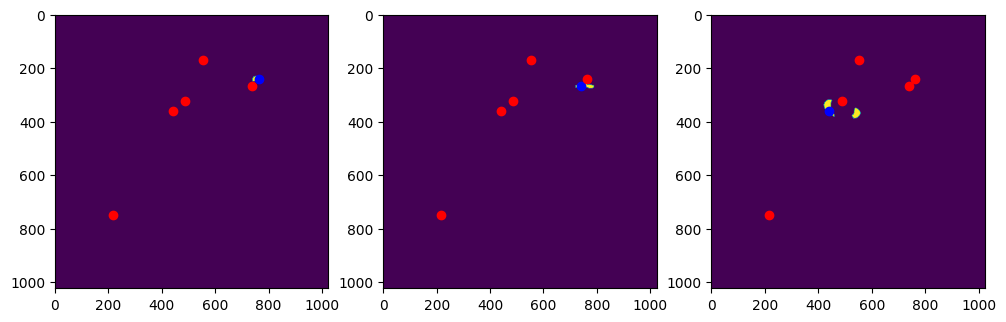

In [7]:
name = ["100034_6861.jpg","100034_6862.jpg","100034_6863.jpg"]
file = ["../../../input/paco-bw-mask-val/kaggle/working/reupdated-paco-masks-val/val/100034_6861.jpg", "../../../input/paco-bw-mask-val/kaggle/working/reupdated-paco-masks-val/val/100034_6862.jpg", "../../../input/paco-bw-mask-val/kaggle/working/reupdated-paco-masks-val/val/100034_6863.jpg"]
idToCordsMap = {}
plt.subplots(1,3,figsize = (12,12))
for i in range(3):
    if name[i].split('_')[0] not in idToCordsMap:
            idToCordsMap[name[i].split('_')[0]] = []
    # print(data["annotation"])
    ann_map = cv2.imread(file[i])
    ann_map = resizeImage(ann_map)
    mask = (ann_map > 150)[:, :, 0].astype(np.uint8)
    coords = np.argwhere(mask > 0)
    # if len(coords) == 0: print("Lol")
    # yx = coords[np.random.randint(len(coords))]  # format: [y, x]
    # point = [[yx[1], yx[0]]]  # format: [x, y] for SAM2
    # idToCordsMap[name[i].split('_')[0]].append(point)
    plt.subplot(1, 3, i + 1)
    labels = [];

    # print(coords)
    for coord in idToCoordsMap['100034']:
        print(coord[0])
        if any(np.array_equal(coord[0][::-1], c) for c in coords):
            labels.append(1)
            plt.scatter(coord[0][0], coord[0][1], color='blue')
        else:
            plt.scatter(coord[0][0], coord[0][1], color='red')
            labels.append(0)
    # print(idToCordsMap[name[i].split('_')[0]][i][0])
    plt.imshow(mask)

In [8]:
def read_single(data):
    # Select random image-mask pair
    ent = data[np.random.randint(len(data))]
    # print(ent)
    if(ent['image'] is None):
        return None,None,None
    Img = cv2.imread(ent["image"])[..., ::-1]  # RGB image
    ann_map = cv2.imread(ent["annotation"])    # BGR annotation map with different part colors
    
    # Resize image and annotation to 1024x1024 (pad if needed)
    Img = resizeImage(Img)
    ann_map = resizeImage(ann_map)
    
    mask = (ann_map > 150)[:, :, 0].astype(np.uint8)
    
    coords = np.argwhere(mask > 0)
    if len(coords) == 0: return Img,mask,None
    # yx = [0,0]
    label = [1]
    point = []
    for coord in idToCoordsMap[getIdFromPath(ent['annotation'])]:
        # print(coord)
        if any(np.array_equal(coord[0][::-1], c) for c in coords):
            point = coord
            break
            
    # points = idToCoordsMap[getIdFromPath(ent['annotation'])]
    # print(f"points = {point} ,labels = {label}")
    return Img, mask, point, label
    
# data_dir=r"../../../input/" # Path to dataset (LabPics 1)
# print(os.getcwd())

# def read_single_test(data, name):
#     # Select random image-mask pair
#     ent ={"image":data_dir+"coco-2017-dataset/coco2017/train2017/"+getName(name),"annotation":data_dir+"less-part-paco-masks/kaggle/working/reupdated-paco-masks/train/"+name}
#     print(ent)
#     if(ent['image'] is None):
#         return None, None ,None ,None
#     Img = cv2.imread(ent["image"])[..., ::-1]  # RGB image
#     ann_map = cv2.imread(ent["annotation"])    # BGR annotation map with different part colors
    
#     # Resize image and annotation to 1024x1024 (pad if needed)
#     Img = resizeImage(Img)
#     ann_map = resizeImage(ann_map)
    
#     mask = (ann_map > 150)[:, :, 0].astype(np.uint8)
    
#     coords = np.argwhere(mask > 0)
#     if len(coords) == 0: return Img,mask,None, None
#     # yx = [0,0]
#     labels = []
#     print(coords)
#     for coord in idToCoordsMap[getIdFromPath(ent['annotation'])]:
#         print(coord[0][::-1])
#         if any(np.array_equal(coord[0][::-1], c) for c in coords):
#             labels.append([1])
#         else:
#             labels.append([0])
            
#     points = idToCoordsMap[getIdFromPath(ent['annotation'])]
#     print(f"points = {points} ,labels = {labels}")
#     return Img, mask, points, labels
    
# def read_batch(data,batch_size=4):
#       limage = []
#       lmask = []
#       linput_point = []
#       for i in range(batch_size):
#               image,mask,input_point = read_single(data)
#               limage.append(image)
#               lmask.append(mask)
#               linput_point.append(input_point)

#       return limage, np.array(lmask), np.array(linput_point),  np.ones([batch_size,1])


[[466, 165]]
[466, 165]


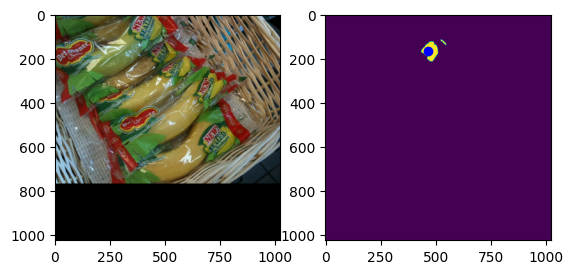

In [9]:
image, mask, input_points, input_labels = read_single(data)  # load data batch
plt.subplot(1, 2, 1)
plt.imshow(image)

plt.subplot(1, 2, 2)
print(input_points)
for indx, point in enumerate(input_points):
    print(point)
    if(input_labels[indx] == [0]): plt.scatter(point[0][0], point[0][1], color="red", marker="o")  # Use scatter to plot a distinct point
    else: plt.scatter(point[0], point[1], color="blue", marker="o") 

plt.imshow(mask)

plt.show()


In [10]:
#  This script is used to load the SAM2 model and create a predictor instance.
# It assumes that the SAM2 model files are located in the specified paths.

sam2_checkpoint = "../checkpoints/sam2.1_hiera_large.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_l.yaml"

sam2_model = build_sam2(model_cfg, sam2_checkpoint, device="cuda")

predictor = SAM2ImagePredictor(sam2_model)


In [11]:
predictor.model.sam_mask_decoder.train(True) # enable training of mask decoder6
predictor.model.sam_prompt_encoder.train(True) # enable training of prompt encoder
predictor.model.image_encoder.train(True) # enable training of image encoder: For this to work you need to scan the code for "no_grad" and remove them all
optimizer=torch.optim.AdamW(params=predictor.model.parameters(),lr=1e-6,weight_decay=4e-6)
scaler = torch.amp.GradScaler('cuda') # mixed precision


In [14]:
# ###### Training loop
# ctr = 0
# for itr in range(1): 
#     with torch.amp.autocast('cuda'): # cast to mix precision
#         try:
#             image,mask,input_point, input_label = read_single(data) # load data batch
#             if None in input_point: continue
#             if mask.shape[0]==0: ctr+= 1; print(ctr); continue # ignore empty batches
#             if image is None: ctr+= 1; print(ctr); continue #ignore image file not found
#             predictor.set_image(image) # apply SAM image encoder to the image
#             # predictor.get_image_embedding()
#             # prompt encoding

#             prd_mask, box, prd_score = Part_Predictor(input_point, image, predictor, score_threshold = 0.87)
#             prd_mask = prd_mask[0]
#             # Segmentaion Loss caclulation

#             gt_mask = torch.tensor(mask.astype(np.float32)).cuda()
#             # seg_loss = (-gt_mask * torch.log(prd_mask + 0.00001) - (1 - gt_mask) * torch.log((1 - prd_mask) + 0.00001)).mean() # cross entropy loss
            
#             # Score loss calculation (intersection over union) IOU
#             # prd_mask = prd_mask[-1]
#             smooth = 1e-5
#             intersection = (prd_mask * gt_mask).sum()
#             union = prd_mask.sum() + gt_mask.sum()
#             dice_loss = 1 - (2 * intersection + smooth) / (union + smooth)
            
#             criterion = torch.nn.BCEWithLogitsLoss()
#             bce = F.binary_cross_entropy_with_logits(prd_mask, gt_mask)
#             # bce = F.binary_cross_entropy(prd_mask, gt_mask)
#             seg_loss = 0.5 * dice_loss + 0.5 * bce
#             # visualise(image, prd_mask.cpu().detach().numpy())
            
#             # print(gt_mask.shape, prd_mask.shape)
#             prd_mask_bin = (prd_mask > 0.5).float().detach()
#             inter = (gt_mask * prd_mask_bin).sum()
#             denom = gt_mask.sum() + prd_mask_bin.sum() - inter + 1e-6
#             iou = inter / denom
#             iou = iou.detach() 
            
#             score_loss = torch.abs(prd_score - iou).mean()
#             loss=seg_loss+score_loss*0.05  # mix losses



            
#             # apply back propogation

#             predictor.model.zero_grad() # empty gradient
#             scaler.scale(loss).backward(retain_graph = True)  # Backpropogate
#             scaler.step(optimizer)
#             scaler.update() # Mix precision

#             if itr%1000==0: torch.save(predictor.model.state_dict(), "model.torch") # save model

#             # Display results

#             if itr==0: mean_iou=0
#             mean_iou = mean_iou * 0.99 + 0.01 * np.mean(iou.cpu().detach().numpy())
#             if itr%1==0: 
#                 print("step: ",itr, "Accuracy(IOU)=",mean_iou)
#         except Exception as e:
#             print(f"Exception : {e}")
#             traceback.print_exc()
#             continue
ctr = 0
for itr in range(100000):
    with torch.amp.autocast('cuda'):
        try:
            image, mask, input_point, input_label = read_single(data)
            if None in input_point or image is None or mask.shape[0] == 0:
                ctr += 1
                print(f"Skipped batch {ctr}")
                continue

            predictor.set_image(image)
            prd_mask, box, prd_score = Part_Predictor(input_point, image, predictor, score_threshold=0.8)
            prd_mask = prd_mask[0]

            gt_mask = torch.tensor(mask.astype(np.float32)).cuda()
            # if itr == 0:
                # plt.subplots(1,3,figsize = (12,12))
                # plt.subplot(1, 3, 1)
                # plt.imshow(image)
                
                # plt.subplot(1, 3, 2)
                # for indx, point in enumerate(input_points):
                #     if(input_labels[indx] == [0]): plt.scatter(point[0], point[1], color="red", marker="o")  # Use scatter to plot a distinct point
                #     else: plt.scatter(point[0], point[1], color="blue", marker="o") 
                # plt.imshow(gt_mask.cpu().detach().numpy())

                # plt.subplot(1,3,3)
                # # print("prd_mask min:", prd_mask[0].cpu().detach().numpy().min().item())
                # # print("prd_mask max:", prd_mask[0].cpu().detach().numpy().max().item())
                # # print((prd_mask[0]>0.3).cpu().detach().numpy().sum())
                # plt.imshow((prd_mask).cpu().detach().numpy(), cmap="viridis")  # or cmap="hot"
                # # plt.colorbar()
                # plt.title("Predicted Mask (Probabilities)")
                # plt.show()
                
            # Dice + BCE loss
            smooth = 1e-5
            intersection = (prd_mask * gt_mask).sum()
            union = prd_mask.sum() + gt_mask.sum()
            dice_loss = 1 - (2 * intersection + smooth) / (union + smooth)

            bce = F.binary_cross_entropy_with_logits(prd_mask, gt_mask)
            seg_loss = 0.5 * dice_loss + 0.5 * bce

            # Score loss (IoU-based)
            prd_mask_bin = (prd_mask > 0.5).float()
            inter = (gt_mask * prd_mask_bin).sum()
            denom = gt_mask.sum() + prd_mask_bin.sum() - inter + 1e-6
            iou = inter / denom
            iou = iou.detach()

            score_loss = torch.abs(prd_score - iou).mean()
            loss = seg_loss + 0.05 * score_loss

            # Backward + update
            predictor.model.zero_grad()
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            # Save model occasionally
            if itr % 1000 == 0:
                torch.save(predictor.model.state_dict(), "model.torch")

            # Monitor performance
            if itr==0: mean_iou=0
            mean_iou = mean_iou * 0.99 + 0.01 * iou.item()
            if itr % 100 == 0:
                print("step:", itr, "Accuracy(IOU)=", mean_iou)

        except Exception as e:
            print(f"Exception: {e}")
            traceback.print_exc()
            continue

step: 0 Accuracy(IOU)= 0.0013640798628330232
step: 100 Accuracy(IOU)= 0.20359614213953084
step: 200 Accuracy(IOU)= 0.22485984717710045
step: 300 Accuracy(IOU)= 0.29150582238657324
step: 400 Accuracy(IOU)= 0.2695454655114024
step: 500 Accuracy(IOU)= 0.2903463051266389
step: 600 Accuracy(IOU)= 0.2743237011772475
step: 700 Accuracy(IOU)= 0.2400196180111998
step: 800 Accuracy(IOU)= 0.2600360806299609
Exception: not enough values to unpack (expected 4, got 3)


Traceback (most recent call last):
  File "/tmp/ipykernel_35/1092340395.py", line 70, in <cell line: 0>
    image, mask, input_point, input_label = read_single(data)
    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
ValueError: not enough values to unpack (expected 4, got 3)


step: 900 Accuracy(IOU)= 0.255070104132148
step: 1000 Accuracy(IOU)= 0.27980865216280093
step: 1100 Accuracy(IOU)= 0.2886092615987544
step: 1200 Accuracy(IOU)= 0.2795071350250937
step: 1300 Accuracy(IOU)= 0.29071606088586766
step: 1400 Accuracy(IOU)= 0.27628034492589576
step: 1500 Accuracy(IOU)= 0.2641133781047314
step: 1600 Accuracy(IOU)= 0.2940511861244761
step: 1700 Accuracy(IOU)= 0.28279371338966197
Exception: not enough values to unpack (expected 4, got 3)


Traceback (most recent call last):
  File "/tmp/ipykernel_35/1092340395.py", line 70, in <cell line: 0>
    image, mask, input_point, input_label = read_single(data)
    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
ValueError: not enough values to unpack (expected 4, got 3)


step: 1800 Accuracy(IOU)= 0.27725040760450725
step: 1900 Accuracy(IOU)= 0.282440787092781
step: 2000 Accuracy(IOU)= 0.296942929819523
step: 2100 Accuracy(IOU)= 0.295005615445111
step: 2200 Accuracy(IOU)= 0.3324265772800596
step: 2300 Accuracy(IOU)= 0.33755741359678304
step: 2400 Accuracy(IOU)= 0.34693551916835014
step: 2500 Accuracy(IOU)= 0.352850447679121
step: 2600 Accuracy(IOU)= 0.3278935293271493
step: 2700 Accuracy(IOU)= 0.32871274245555016
step: 2800 Accuracy(IOU)= 0.3568618050499854
step: 2900 Accuracy(IOU)= 0.3691727164649095
step: 3000 Accuracy(IOU)= 0.37278562612699395
step: 3100 Accuracy(IOU)= 0.3599840079820168
step: 3200 Accuracy(IOU)= 0.3741238182415446
step: 3300 Accuracy(IOU)= 0.3718911966194417
step: 3400 Accuracy(IOU)= 0.39217122794612475
step: 3500 Accuracy(IOU)= 0.3728112813633729
step: 3600 Accuracy(IOU)= 0.3707249921855579
step: 3700 Accuracy(IOU)= 0.38149314024491804
step: 3800 Accuracy(IOU)= 0.37390065186003824
step: 3900 Accuracy(IOU)= 0.3816700130719937
step: 

Traceback (most recent call last):
  File "/tmp/ipykernel_35/1092340395.py", line 70, in <cell line: 0>
    image, mask, input_point, input_label = read_single(data)
    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
ValueError: not enough values to unpack (expected 4, got 3)


step: 6800 Accuracy(IOU)= 0.349303111958198
step: 6900 Accuracy(IOU)= 0.4046788768663087
step: 7000 Accuracy(IOU)= 0.400106638363123
step: 7100 Accuracy(IOU)= 0.41848077909640274
step: 7200 Accuracy(IOU)= 0.4025533886548821
step: 7300 Accuracy(IOU)= 0.3951903579647341
step: 7400 Accuracy(IOU)= 0.40910424061773376
step: 7500 Accuracy(IOU)= 0.3602183715016903
step: 7600 Accuracy(IOU)= 0.3634899026228352
step: 7700 Accuracy(IOU)= 0.4115873691705805
step: 7800 Accuracy(IOU)= 0.372634322491618
step: 7900 Accuracy(IOU)= 0.40906426581633143
step: 8000 Accuracy(IOU)= 0.3749908246006159
step: 8100 Accuracy(IOU)= 0.3748734952619528
step: 8200 Accuracy(IOU)= 0.37914011720846474
step: 8300 Accuracy(IOU)= 0.38761524911446626
step: 8400 Accuracy(IOU)= 0.41752667689274603
step: 8500 Accuracy(IOU)= 0.40832588906469275
step: 8600 Accuracy(IOU)= 0.40645426562233455
step: 8700 Accuracy(IOU)= 0.4457562679597985
step: 8800 Accuracy(IOU)= 0.4000898698528837
step: 8900 Accuracy(IOU)= 0.42014856710363596
step

Traceback (most recent call last):
  File "/tmp/ipykernel_35/1092340395.py", line 70, in <cell line: 0>
    image, mask, input_point, input_label = read_single(data)
    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
ValueError: not enough values to unpack (expected 4, got 3)


step: 9100 Accuracy(IOU)= 0.41307449324215195
step: 9200 Accuracy(IOU)= 0.4163584794576295
step: 9300 Accuracy(IOU)= 0.39436489363213434
step: 9400 Accuracy(IOU)= 0.40745770425910866
step: 9500 Accuracy(IOU)= 0.402442396548566
step: 9600 Accuracy(IOU)= 0.38915723923179746
step: 9700 Accuracy(IOU)= 0.3752574174120294
step: 9800 Accuracy(IOU)= 0.3847677339640164
step: 9900 Accuracy(IOU)= 0.37688139452852687
step: 10000 Accuracy(IOU)= 0.4068330020161656
step: 10100 Accuracy(IOU)= 0.43112283944464574
step: 10200 Accuracy(IOU)= 0.3993347387856032
step: 10300 Accuracy(IOU)= 0.39768301397676775
step: 10400 Accuracy(IOU)= 0.3886834162874175
step: 10500 Accuracy(IOU)= 0.39148852945907264
step: 10600 Accuracy(IOU)= 0.3995025168982039
step: 10700 Accuracy(IOU)= 0.37661796922043
step: 10800 Accuracy(IOU)= 0.41417990637058383
step: 10900 Accuracy(IOU)= 0.41619639465027974
step: 11000 Accuracy(IOU)= 0.41944243358228367
step: 11100 Accuracy(IOU)= 0.4387527679318213
step: 11200 Accuracy(IOU)= 0.442785

Traceback (most recent call last):
  File "/tmp/ipykernel_35/1092340395.py", line 70, in <cell line: 0>
    image, mask, input_point, input_label = read_single(data)
    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
ValueError: not enough values to unpack (expected 4, got 3)


step: 13400 Accuracy(IOU)= 0.35459648317661846
step: 13500 Accuracy(IOU)= 0.3543789141606447
step: 13600 Accuracy(IOU)= 0.37194385275890973


KeyboardInterrupt: 

# Testing the model

In [1]:
%cd ~/../kaggle/working
!git clone https://github.com/RSourceCode/SAM2.git

/kaggle/working
fatal: destination path 'SAM2' already exists and is not an empty directory.


In [2]:
!pip install sam2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.8/152.8 kB 3.9 MB/s eta 0:00:00a 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 29.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━

In [ ]:
%cd SAM2
!pip install -e .

/kaggle/working/SAM2
Obtaining file:///kaggle/working/SAM2
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done


In [ ]:
%cd checkpoints
!bash download_ckpts.sh
%cd ../notebooks

In [15]:
# Read image from url helper function
import cv2
import urllib.request
import numpy as np

def imread_from_url(url):
    try:
        req = urllib.request.urlopen(url)
        arr = np.asarray(bytearray(req.read()), dtype=np.uint8)
        img = cv2.imdecode(arr, -1)
        return img
    except Exception as e:
        print(f"Error reading image from URL: {e}")
        return None

In [18]:
!ls

automatic_mask_generator_example.ipynb	Img-Fine_Tuner.ipynb
dataset					model.torch
image_predictor_example.ipynb		video_predictor_example.ipynb
images					videos


In [47]:
# segment image region using  fine tune model
# See Train.py on how to fine tune/train the model
import numpy as np
import torch
import cv2
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor

# use bfloat16 for the entire script (memory efficient)
torch.autocast(device_type="cuda", dtype=torch.bfloat16).__enter__()

# Load image


# image_path = r"sample_image.jpg" # path to image
# mask_path = r"sample_mask.png" # path to mask, the mask will define the image region to segment

def read_image(): # read and resize image and mask
        # img = cv2.imread(image_path)[...,::-1]  # read image as rgb
        img = imread_from_url("https://c8.alamy.com/comp/K228XX/this-image-shows-an-overview-of-the-layers-of-the-human-body-K228XX.jpg")
        # mask = cv2.imread(mask_path,0) # mask of the region we want to segment

        # Resize image to maximum size of 1024

        r = np.min([1024 / img.shape[1], 1024 / img.shape[0]])
        img = cv2.resize(img, (int(img.shape[1] * r), int(img.shape[0] * r)))
        # mask = cv2.resize(mask, (int(mask.shape[1] * r), int(mask.shape[0] * r)),interpolation=cv2.INTER_NEAREST)
        return img
image = read_image()
num_samples = 30 # number of points/segment to sample
# def get_points(mask,num_points): # Sample points inside the input mask
#         points=[]
#         for i in range(num_points):
#             coords = np.argwhere(mask > 0)
#             yx = np.array(coords[np.random.randint(len(coords))])
#             points.append([[yx[1], yx[0]]])
        
        # return np.array(points)
# input_points = get_points(mask,num_samples)

input_points = np.array([[[[250,40]]],[[[50,500]]],[[[190,320]]],[[[360,320]]],[[[190,600]]]])
# read image and sample points


# Load model you need to have pretrained model already made
sam2_checkpoint = "../checkpoints/sam2.1_hiera_large.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_l.yaml"
sam2_model = build_sam2(model_cfg, sam2_checkpoint, device="cuda")

# Build net and load weights
predictor = SAM2ImagePredictor(sam2_model)
predictor.model.load_state_dict(torch.load("model.torch"))

# predict mask
prd_masks = []
for input_point in input_points:
    with torch.no_grad():
            predictor.set_image(image)
            masks, scores, logits = predictor.predict(
                point_coords=input_point,
                point_labels=np.ones([input_point.shape[0],1])
            )
    prd_masks.append(masks[0])

# Short predicted masks from high to low score

# masks=masks[:,0].astype(bool)
# shorted_masks = masks[np.argsort(scores[:,0])][::-1].astype(bool)

# # Stitch predicted mask into one segmentation mask

# seg_map = np.zeros_like(shorted_masks[0],dtype=np.uint8)
# occupancy_mask = np.zeros_like(shorted_masks[0],dtype=bool)
# for i in range(shorted_masks.shape[0]):
#     mask = shorted_masks[i]
#     if (mask*occupancy_mask).sum()/mask.sum()>0.15: continue
#     mask[occupancy_mask]=0
#     seg_map[mask]=i+1
#     occupancy_mask[mask]=1

# # create colored annotation map
# height, width = seg_map.shape

# # Create an empty RGB image for the colored annotation
# rgb_image = np.zeros((seg_map.shape[0], seg_map.shape[1], 3), dtype=np.uint8)
# for id_class in range(1,seg_map.max()+1):
#     rgb_image[seg_map == id_class] = [np.random.randint(255), np.random.randint(255), np.random.randint(255)]

# save and display

# cv2.imwrite("annotation.png",rgb_image)
# cv2.imwrite("mix.png",(rgb_image/2+image/2).astype(np.uint8))
import matplotlib.pyplot as plt

fig, axes = plt.subplots(5, 2, figsize=(12, 12))
axes = axes.flatten()  # Flatten for easier indexing (0 to 7)

for i in range(5):
    # Plot original image with red point
    axes[2*i].imshow(image[:, :, ::-1])  # Convert BGR to RGB
    axes[2*i].scatter(input_points[i][0][0][0], input_points[i][0][0][1], color='red')
    axes[2*i].set_title(f"Image {i+1}")
    axes[2*i].axis('on')

    # Plot predicted mask
    axes[2*i + 1].imshow(prd_masks[i], cmap='gray')
    axes[2*i + 1].set_title(f"Predicted Mask {i+1}")
    axes[2*i + 1].axis('on')

plt.tight_layout()
plt.show()

OutOfMemoryError: CUDA out of memory. Tried to allocate 512.00 MiB. GPU 0 has a total capacity of 14.74 GiB of which 44.12 MiB is free. Process 3844 has 14.70 GiB memory in use. Of the allocated memory 13.28 GiB is allocated by PyTorch, and 1.27 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

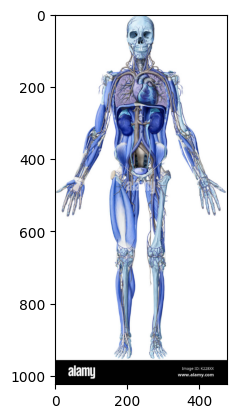

In [43]:
plt.imshow(image)

In [49]:
import shutil
shutil.make_archive('part-model', 'zip', '../notebooks')

OSError: [Errno 28] No space left on device

In [51]:
!pip install -q kaggle


In [52]:
import json
import os

# Upload kaggle.json manually to your notebook first (use sidebar file upload)
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
